In [1]:
import pandas as pd
import numpy as np
import ast
from datetime import timedelta

1. Integración de bases de datos 

In [2]:
# 1. Cargar archivo de pasos totales diarios
df_steps = pd.read_csv("data/aggregates_steps.csv")

# 2. Asegurarte de que la columna 'date' esté como datetime
df_steps['date'] = pd.to_datetime(df_steps['date'])

# 3. Renombrar la columna 'value' a 'steps_total'
df_steps.rename(columns={'value': 'steps_total'}, inplace=True)

# 4. Ordenar por fecha 
df_steps.sort_values('date', inplace=True)

# 5. Crear la base principal
df_base = df_steps.copy()

In [3]:
df_base.tail()

,date,steps_total
4,2024-10-13,16236
3,2024-10-14,7685
2,2024-10-15,8741
1,2024-10-16,8732
0,2024-10-17,3383


In [4]:
# Cargar el archivo
ruta = "data/raw_tracker_steps.csv"
df = pd.read_csv(ruta)

# Forzar conversión a datetime incluyendo zona horaria
df["start"] = pd.to_datetime(df["start"], utc=True, errors='coerce')

print(df["start"].dtype)
print(df["start"].dt.hour.head())


datetime64[ns, UTC]
0    13
1    13
2    13
3    14
4    14
Name: start, dtype: int32


In [5]:

# 1. Cargar el archivo
ruta = "data/raw_tracker_steps.csv"
df = pd.read_csv(ruta)

# 2. Convertir 'start' a datetime con zona horaria UTC
df["start"] = pd.to_datetime(df["start"], utc=True, errors='coerce')

# 3. Eliminar filas inválidas
df = df.dropna(subset=["start"])

# 4. Convertir a horario local (España, por ejemplo)
df["start"] = df["start"].dt.tz_convert("Europe/Madrid")

# 5. Filtrar filas cuyo bloque comience entre 19:00 y 23:59
df = df[df["start"].dt.hour.between(19, 23)]

# 6. Ordenar por fecha (opcional)
df = df.sort_values(by="start", ascending=False)

# 7. Expandir por minuto
expanded_rows = []

for _, row in df.iterrows():
    start_time = row["start"]
    duration_list = eval(row["duration"]) if isinstance(row["duration"], str) else row["duration"]
    value_list = eval(row["value"]) if isinstance(row["value"], str) else row["value"]

    for i, steps in enumerate(value_list):
        minute_time = start_time + pd.Timedelta(minutes=i)
        expanded_rows.append({"datetime": minute_time, "steps": steps})

# 8. Crear DataFrame con una fila por minuto
expanded_df = pd.DataFrame(expanded_rows)

# 9. Extraer fecha para agrupar
expanded_df["date"] = pd.to_datetime(expanded_df["datetime"].dt.date)

# 10. Agrupar por día y sumar pasos
df_steps_evening = expanded_df.groupby("date")["steps"].sum().reset_index()
df_steps_evening.rename(columns={"steps": "steps_evening"}, inplace=True)

# 11. Unir con tu base principal
df_base = df_base.merge(df_steps_evening, on="date", how="left")


In [6]:
df_base

,date,steps_total,steps_evening
0,2013-06-01,0,NaN
1,2013-06-02,0,NaN
2,2013-06-03,0,NaN
3,2013-06-04,0,NaN
4,2013-06-05,0,NaN
...,...,...,...
4119,2024-10-13,16236,6549.0
4120,2024-10-14,7685,714.0
4121,2024-10-15,8741,657.0
4122,2024-10-16,8732,1715.0


In [6]:
# 1. Cargar el archivo
df_activity = pd.read_csv("data/raw_tracker_Activity subcategory.csv")

# 2. Convertir la columna 'start' a datetime con zona horaria
df_activity['start'] = pd.to_datetime(df_activity['start'], utc=True, errors='coerce')
df_activity = df_activity.dropna(subset=["start"])

# (opcional) Convertir a zona horaria local
df_activity['start'] = df_activity['start'].dt.tz_convert('Europe/Madrid')

# 3. Expandir las filas: una fila por minuto

expanded_rows = []

for _, row in df_activity.iterrows():
    start_time = row['start']
    durations = ast.literal_eval(row['duration']) if isinstance(row['duration'], str) else row['duration']
    values = ast.literal_eval(row['value']) if isinstance(row['value'], str) else row['value']

    for i, activity in enumerate(values):
        minute_time = start_time + timedelta(minutes=i)
        expanded_rows.append({'datetime': minute_time, 'activity_id': activity})

df_expanded_act = pd.DataFrame(expanded_rows)

# 4. Extraer fecha
df_expanded_act['date'] = pd.to_datetime(df_expanded_act['datetime'].dt.date)

# 5. Agrupar por día y contar actividades distintas
df_activity_count = df_expanded_act.groupby('date')['activity_id'].nunique().reset_index()
df_activity_count.rename(columns={'activity_id': 'activity_count'}, inplace=True)

# 6. Unir con df_base
df_base = df_base.merge(df_activity_count, on='date', how='left')


In [8]:
df_activity_count



,date,activity_count
0,2018-04-27,1
1,2018-04-28,3
2,2018-04-29,2
3,2018-04-30,2
4,2018-05-01,2
...,...,...
1528,2024-10-13,1
1529,2024-10-14,2
1530,2024-10-15,2
1531,2024-10-16,1


In [7]:
df_base.tail(20)

,date,steps_total,steps_evening,activity_count
4104,2024-09-28,22160,18284.0,2.0
4105,2024-09-29,7533,1180.0,2.0
4106,2024-09-30,3357,1958.0,1.0
4107,2024-10-01,7254,696.0,1.0
4108,2024-10-02,1630,719.0,1.0
4109,2024-10-03,16791,11736.0,2.0
4110,2024-10-04,4996,2059.0,1.0
4111,2024-10-05,9752,327.0,1.0
4112,2024-10-06,5994,5223.0,2.0
4113,2024-10-07,4212,850.0,1.0


In [8]:
# Cargar el archivo sleep.csv
df_sleep = pd.read_csv("data/sleep.csv")  # Ajusta ruta si es distinta

# Convertir columnas de tiempo a datetime
df_sleep['from'] = pd.to_datetime(df_sleep['from'], utc=True, errors='coerce')
df_sleep['to'] = pd.to_datetime(df_sleep['to'], utc=True, errors='coerce')

# Calcular duración en minutos
df_sleep['sleep_minutes_light'] = df_sleep['light (s)'] / 60
df_sleep['sleep_minutes_deep'] = df_sleep['deep (s)'] / 60
df_sleep['sleep_minutes_total'] = df_sleep['sleep_minutes_light'] + df_sleep['sleep_minutes_deep']

# Renombrar columnas para uniformidad
df_sleep.rename(columns={
    'from': 'sleep_start',
    'to': 'sleep_end',
    'wake up': 'sleep_wakeups'
}, inplace=True)

# Crear fecha de referencia para sueño previo (día de despertar)
df_sleep['sleep_end_date'] = df_sleep['sleep_end'].dt.date
df_sleep['sleep_end_date'] = pd.to_datetime(df_sleep['sleep_end_date'])

# Crear fecha de referencia para sueño posterior (noche que empieza en D)
df_sleep['local_start'] = df_sleep['sleep_start'].dt.tz_convert('Europe/Madrid')
df_sleep['local_start_date'] = df_sleep['local_start'].dt.date
df_sleep['local_start_hour'] = df_sleep['local_start'].dt.hour

# ---------- SUEÑO PREVIO ----------
df_sleep_prev = df_sleep.copy()
df_sleep_prev['date'] = df_sleep_prev['sleep_end_date']  # Asignar al día D si se despierta ese día
df_sleep_prev = df_sleep_prev[['date', 'sleep_start', 'sleep_end',
                               'sleep_minutes_total', 'sleep_minutes_light',
                               'sleep_minutes_deep', 'sleep_wakeups']]
df_sleep_prev.columns = ['date'] + [f'sleep_prev_{col}' for col in df_sleep_prev.columns[1:]]

# ---------- SUEÑO POSTERIOR ----------
df_sleep_next = df_sleep.copy()

# Condición: sueño que empieza entre 19:00 de D y <12:00 del D+1 (en horario local)
df_sleep_next = df_sleep_next[
    (df_sleep_next['local_start_hour'] >= 19) |
    (df_sleep_next['local_start_hour'] < 12)
]

# Si empieza <12h, es sueño que empezó pasada la medianoche ➝ restamos un día para asignarlo a D
df_sleep_next['date'] = df_sleep_next['local_start'].apply(
    lambda x: x.date() if x.hour >= 19 else (x - pd.Timedelta(days=1)).date()
)
df_sleep_next['date'] = pd.to_datetime(df_sleep_next['date'])

df_sleep_next = df_sleep_next[['date', 'sleep_start', 'sleep_end',
                               'sleep_minutes_total', 'sleep_minutes_light',
                               'sleep_minutes_deep', 'sleep_wakeups']]
df_sleep_next.columns = ['date'] + [f'sleep_next_{col}' for col in df_sleep_next.columns[1:]]

# ---------- UNIÓN CON df_base ----------
df_base = df_base.merge(df_sleep_prev, on='date', how='left')
df_base = df_base.merge(df_sleep_next, on='date', how='left')


In [11]:
df_sleep_prev.tail(20)

,date,sleep_prev_sleep_start,sleep_prev_sleep_end,sleep_prev_sleep_minutes_total,sleep_prev_sleep_minutes_light,sleep_prev_sleep_minutes_deep,sleep_prev_sleep_wakeups
1290,2024-09-10,2024-09-09 21:56:00+00:00,2024-09-10 05:42:00+00:00,443.0,291.0,152.0,2
1291,2024-09-11,2024-09-10 20:40:00+00:00,2024-09-11 04:45:00+00:00,449.0,303.0,146.0,2
1292,2024-09-12,2024-09-11 21:29:00+00:00,2024-09-12 05:19:00+00:00,431.0,263.0,168.0,2
1293,2024-09-13,2024-09-12 21:05:00+00:00,2024-09-13 05:49:00+00:00,476.0,315.0,161.0,2
1294,2024-09-15,2024-09-14 23:27:00+00:00,2024-09-15 04:41:00+00:00,292.0,138.0,154.0,1
1295,2024-09-17,2024-09-16 21:20:00+00:00,2024-09-17 07:42:00+00:00,517.0,331.0,186.0,3
1296,2024-09-20,2024-09-19 21:25:00+00:00,2024-09-20 06:22:00+00:00,515.0,365.0,150.0,2
1297,2024-09-22,2024-09-22 09:11:00+00:00,2024-09-22 12:02:00+00:00,151.0,96.0,55.0,1
1298,2024-09-25,2024-09-24 22:57:00+00:00,2024-09-25 05:49:00+00:00,402.0,249.0,153.0,0
1299,2024-09-28,2024-09-27 22:34:00+00:00,2024-09-28 02:11:00+00:00,203.0,100.0,103.0,1


In [12]:
df_sleep_next

,date,sleep_next_sleep_start,sleep_next_sleep_end,sleep_next_sleep_minutes_total,sleep_next_sleep_minutes_light,sleep_next_sleep_minutes_deep,sleep_next_sleep_wakeups
0,2018-04-26,2018-04-26 22:10:00+00:00,2018-04-27 03:47:00+00:00,327.0,182.000000,145.000000,1
1,2018-04-27,2018-04-27 23:47:00+00:00,2018-04-28 07:05:00+00:00,399.0,295.000000,104.000000,2
2,2018-04-28,2018-04-28 23:20:00+00:00,2018-04-29 07:18:00+00:00,453.0,329.000000,124.000000,1
3,2018-04-29,2018-04-30 01:15:00+00:00,2018-04-30 07:34:00+00:00,353.0,229.000000,124.000000,2
4,2018-04-30,2018-04-30 20:58:00+00:00,2018-05-01 06:20:00+00:00,543.0,259.983333,283.016667,1
...,...,...,...,...,...,...,...
1305,2024-10-09,2024-10-09 23:56:00+00:00,2024-10-10 07:19:00+00:00,417.0,255.000000,162.000000,2
1306,2024-10-10,2024-10-10 22:28:00+00:00,2024-10-11 06:28:00+00:00,442.0,297.000000,145.000000,2
1307,2024-10-11,2024-10-11 22:40:00+00:00,2024-10-12 06:43:00+00:00,452.0,268.000000,184.000000,2
1308,2024-10-12,2024-10-12 23:45:00+00:00,2024-10-13 05:55:00+00:00,361.0,259.000000,102.000000,0


In [13]:
df_base.head(20)

,date,steps_total,steps_evening,activity_count,sleep_prev_sleep_start,sleep_prev_sleep_end,sleep_prev_sleep_minutes_total,sleep_prev_sleep_minutes_light,sleep_prev_sleep_minutes_deep,sleep_prev_sleep_wakeups,sleep_next_sleep_start,sleep_next_sleep_end,sleep_next_sleep_minutes_total,sleep_next_sleep_minutes_light,sleep_next_sleep_minutes_deep,sleep_next_sleep_wakeups
0,2013-06-01,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,2013-06-02,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
2,2013-06-03,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
3,2013-06-04,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4,2013-06-05,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
5,2013-06-06,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
6,2013-06-07,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
7,2013-06-08,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
8,2013-06-09,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
9,2013-06-10,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [9]:
# Extraer solo la hora como tipo datetime.time 
df_base['sleep_prev_sleep_start'] = pd.to_datetime(df_base['sleep_prev_sleep_start'], errors='coerce').dt.time
df_base['sleep_prev_sleep_end'] = pd.to_datetime(df_base['sleep_prev_sleep_end'], errors='coerce').dt.time

df_base['sleep_next_sleep_start'] = pd.to_datetime(df_base['sleep_next_sleep_start'], errors='coerce').dt.time
df_base['sleep_next_sleep_end'] = pd.to_datetime(df_base['sleep_next_sleep_end'], errors='coerce').dt.time



In [15]:
df_base.tail(20)

,date,steps_total,steps_evening,activity_count,sleep_prev_sleep_start,sleep_prev_sleep_end,sleep_prev_sleep_minutes_total,sleep_prev_sleep_minutes_light,sleep_prev_sleep_minutes_deep,sleep_prev_sleep_wakeups,sleep_next_sleep_start,sleep_next_sleep_end,sleep_next_sleep_minutes_total,sleep_next_sleep_minutes_light,sleep_next_sleep_minutes_deep,sleep_next_sleep_wakeups
4263,2024-09-28,22160,18284.0,2.0,22:34:00,02:11:00,203.0,100.0,103.0,1.0,02:39:00,08:00:00,311.0,188.0,123.0,0.0
4264,2024-09-29,7533,1180.0,2.0,02:39:00,08:00:00,311.0,188.0,123.0,0.0,NaT,NaT,NaN,NaN,NaN,NaN
4265,2024-09-30,3357,1958.0,1.0,NaT,NaT,NaN,NaN,NaN,NaN,01:47:00,06:51:00,288.0,199.0,89.0,1.0
4266,2024-10-01,7254,696.0,1.0,01:47:00,06:51:00,288.0,199.0,89.0,1.0,NaT,NaT,NaN,NaN,NaN,NaN
4267,2024-10-02,1630,719.0,1.0,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4268,2024-10-03,16791,11736.0,2.0,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4269,2024-10-04,4996,2059.0,1.0,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4270,2024-10-05,9752,327.0,1.0,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4271,2024-10-06,5994,5223.0,2.0,NaT,NaT,NaN,NaN,NaN,NaN,21:30:00,06:19:00,499.0,344.0,155.0,2.0
4272,2024-10-07,4212,850.0,1.0,21:30:00,06:19:00,499.0,344.0,155.0,2.0,22:43:00,05:28:00,397.0,247.0,150.0,0.0


2. Exploración preliminar de datos

In [16]:
# Ver dimensiones del DataFrame
print(f"Número de filas: {df_base.shape[0]}")
print(f"Número de columnas: {df_base.shape[1]}")

Número de filas: 4283
Número de columnas: 16


In [10]:
# Tipos de datos
pd.set_option('display.max_rows', None)

print("Tipos de datos:")
print(df_base.dtypes)

# Valores nulos por variable
print("\nValores nulos por columna:")
print(df_base.isna().sum())

Tipos de datos:
date                              datetime64[ns]
steps_total                                int64
steps_evening                            float64
activity_count                           float64
sleep_prev_sleep_start                    object
sleep_prev_sleep_end                      object
sleep_prev_sleep_minutes_total           float64
sleep_prev_sleep_minutes_light           float64
sleep_prev_sleep_minutes_deep            float64
sleep_prev_sleep_wakeups                 float64
sleep_next_sleep_start                    object
sleep_next_sleep_end                      object
sleep_next_sleep_minutes_total           float64
sleep_next_sleep_minutes_light           float64
sleep_next_sleep_minutes_deep            float64
sleep_next_sleep_wakeups                 float64
dtype: object

Valores nulos por columna:
date                                 0
steps_total                          0
steps_evening                     2733
activity_count                    2592
sl

In [11]:
pd.reset_option('display.max_rows')

In [19]:
# Estadísticas descriptivas generales para variables numéricas
df_base.describe()


,date,steps_total,steps_evening,activity_count,sleep_prev_sleep_minutes_total,sleep_prev_sleep_minutes_light,sleep_prev_sleep_minutes_deep,sleep_prev_sleep_wakeups,sleep_next_sleep_minutes_total,sleep_next_sleep_minutes_light,sleep_next_sleep_minutes_deep,sleep_next_sleep_wakeups
count,4283,4283.000000,1550.000000,1691.000000,1338.000000,1338.000000,1338.000000,1338.000000,1287.000000,1287.000000,1287.000000,1287.000000
mean,2019-02-13 18:23:27.051132416,3686.983189,2275.674194,1.504435,364.260825,220.606141,143.654684,1.195815,379.307692,231.805789,147.501904,1.222222
min,2013-06-01 00:00:00,0.000000,0.000000,1.000000,74.000000,6.000000,3.000000,0.000000,88.000000,12.000000,3.000000,0.000000
25%,2016-05-06 12:00:00,0.000000,516.250000,1.000000,313.000000,175.000000,111.000000,0.000000,326.000000,186.500000,117.000000,0.000000
50%,2019-03-10 00:00:00,0.000000,1168.500000,1.000000,381.000000,229.000000,145.000000,1.000000,388.000000,235.000000,148.000000,1.000000
75%,2021-11-21 12:00:00,6429.500000,2511.000000,2.000000,438.000000,276.000000,174.000000,2.000000,442.000000,280.000000,175.000000,2.000000
max,2024-10-17 00:00:00,42123.000000,24703.000000,3.000000,742.000000,442.000000,388.016667,6.000000,742.000000,442.000000,388.016667,6.000000
std,NaN,5895.482132,2958.157237,0.623370,110.901158,78.839768,49.968230,1.078343,96.167371,69.508059,47.125732,1.073665


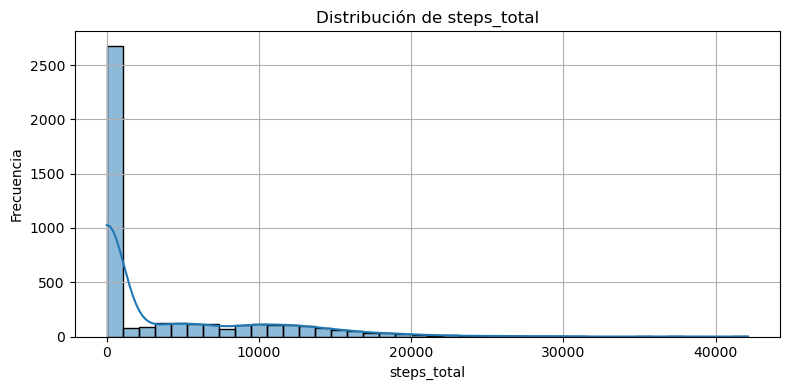

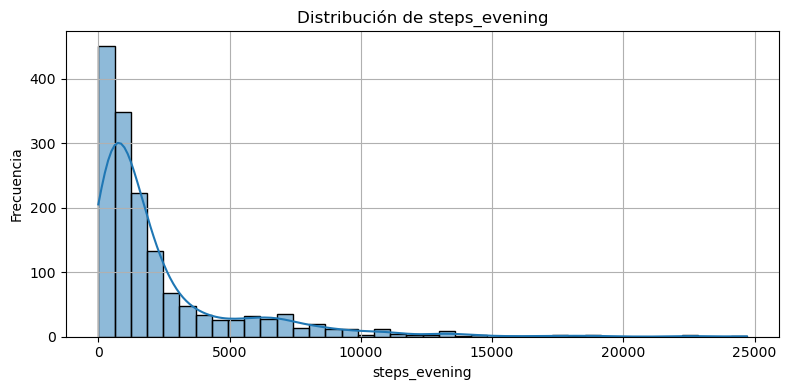

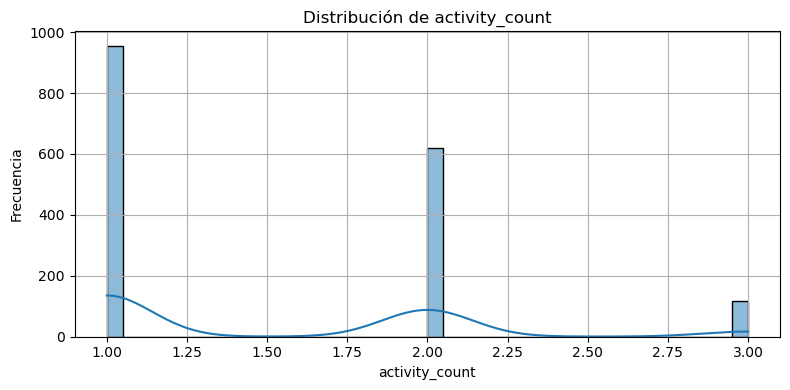

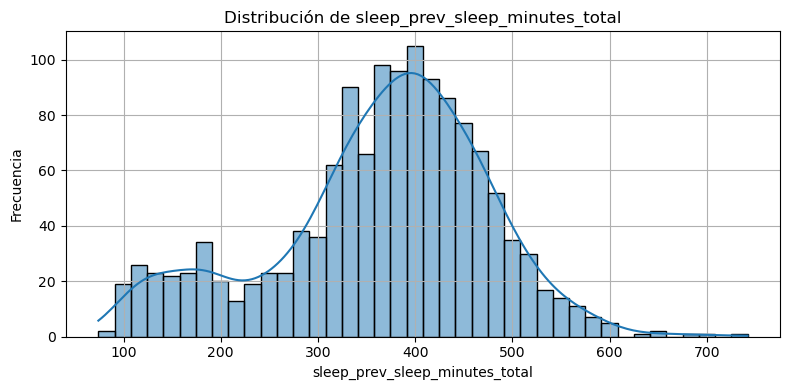

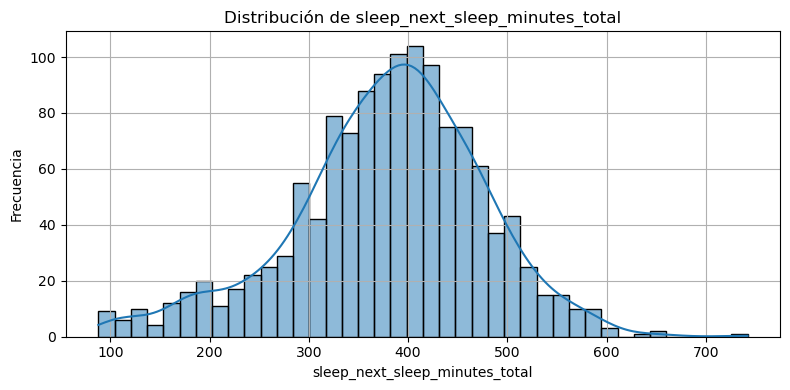

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables a visualizar
variables = [
    'steps_total',
    'steps_evening',
    'activity_count',
    'sleep_prev_sleep_minutes_total',
    'sleep_next_sleep_minutes_total'
]

# Crear histogramas
for var in variables:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_base, x=var, bins=40, kde=True)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


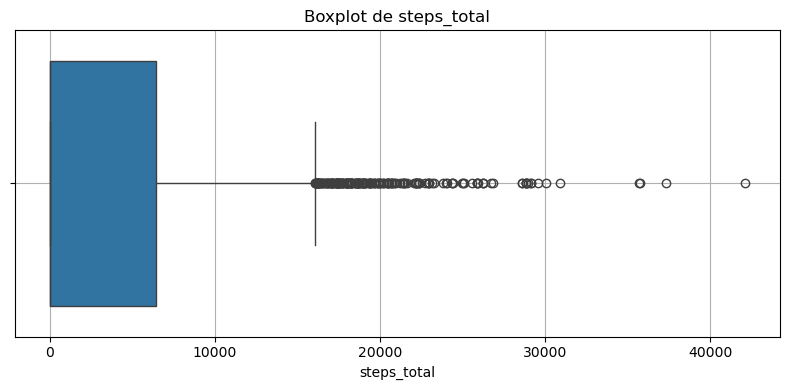

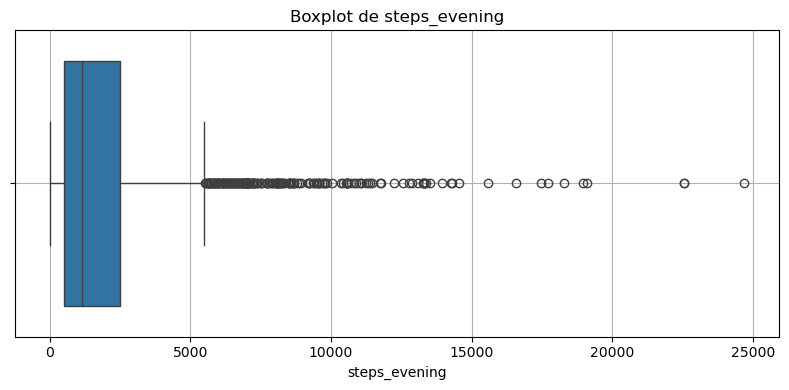

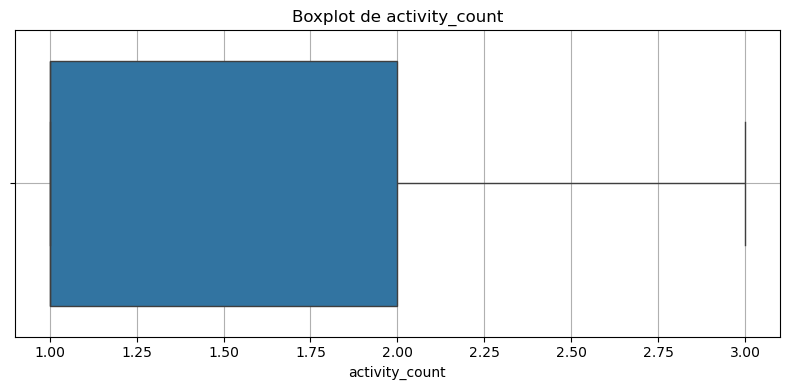

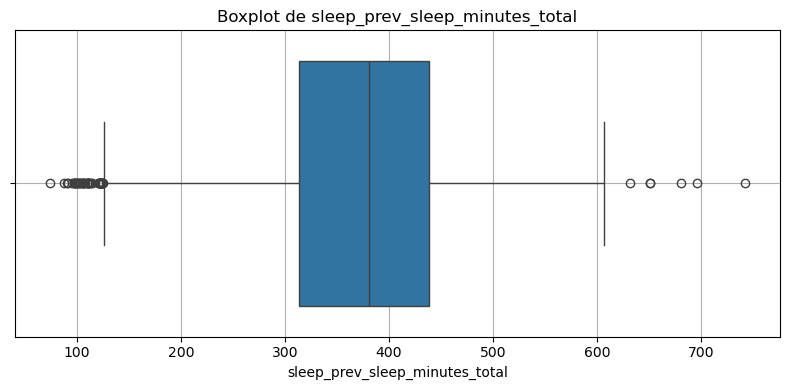

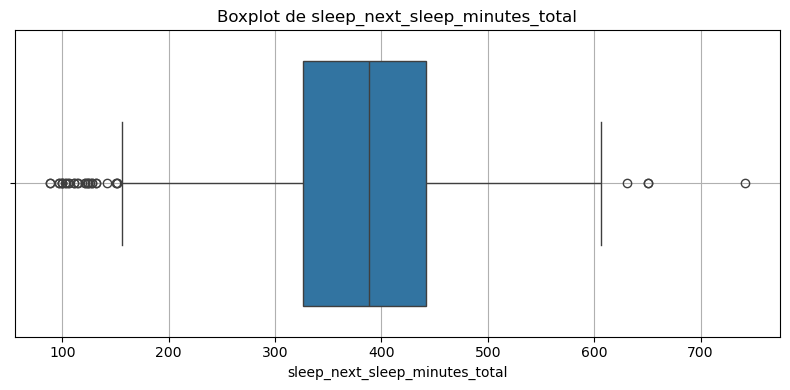

In [21]:

# Lista de variables cuantitativas
variables = [
    'steps_total',
    'steps_evening',
    'activity_count',
    'sleep_prev_sleep_minutes_total',
    'sleep_next_sleep_minutes_total'
]

# Crear boxplots
for var in variables:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_base, x=var)
    plt.title(f'Boxplot de {var}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


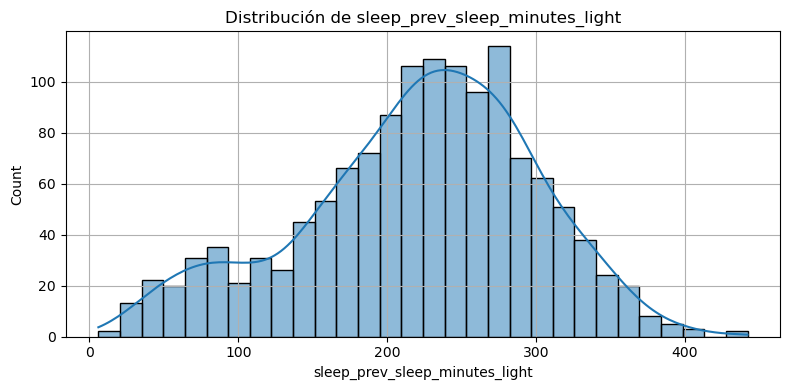

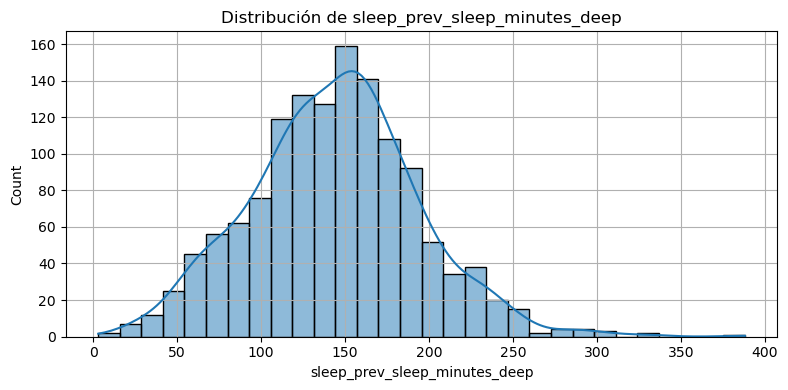

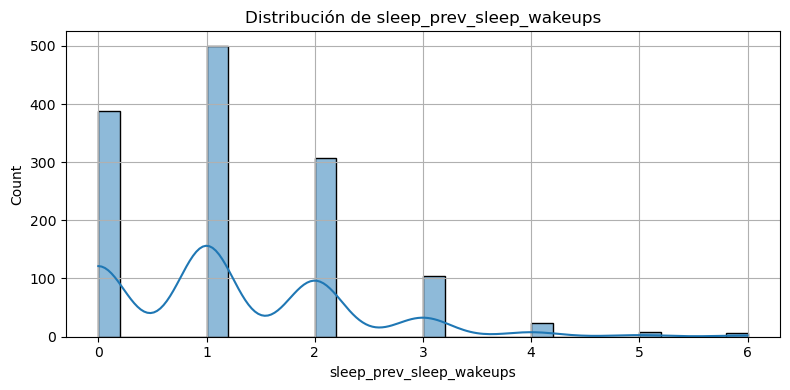

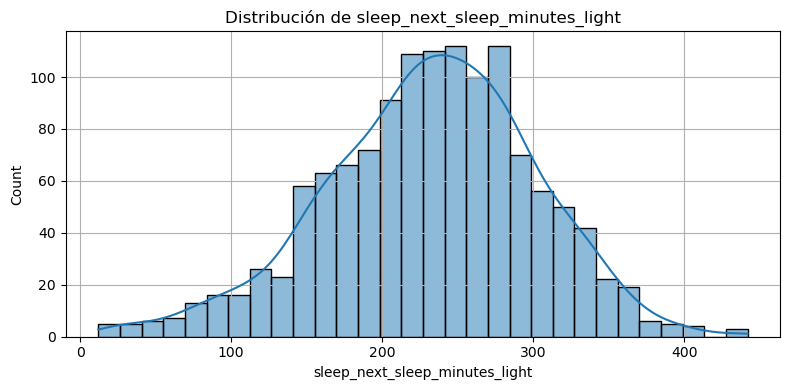

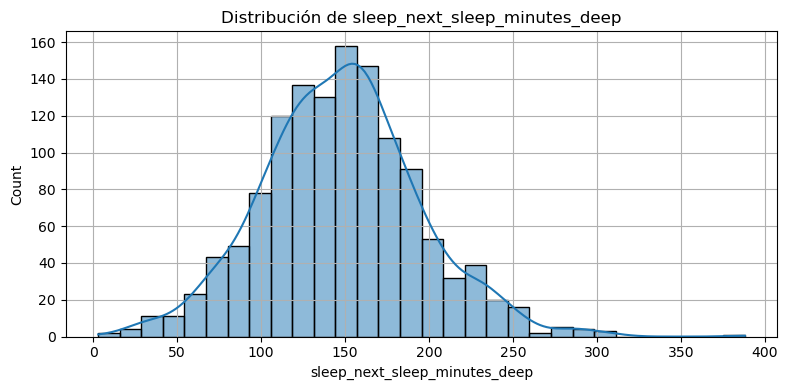

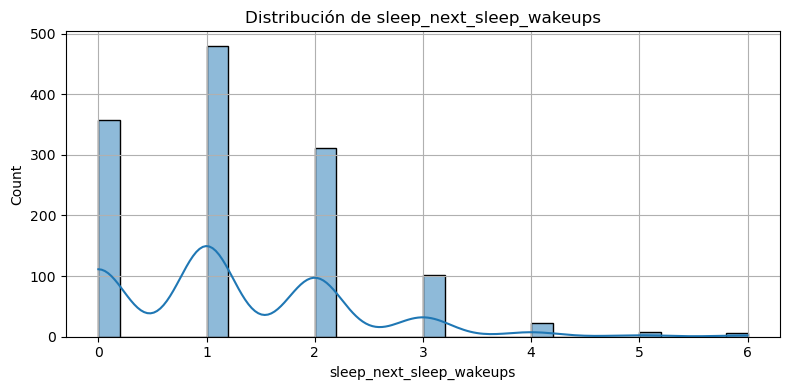

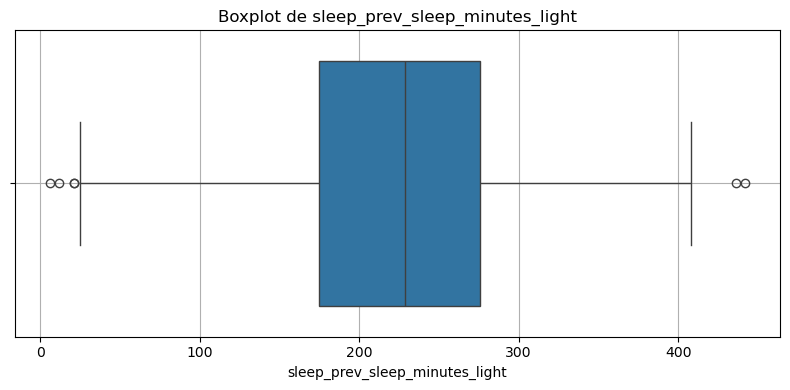

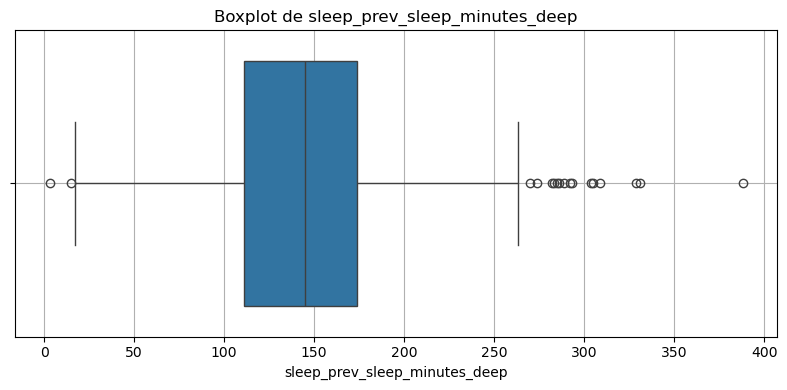

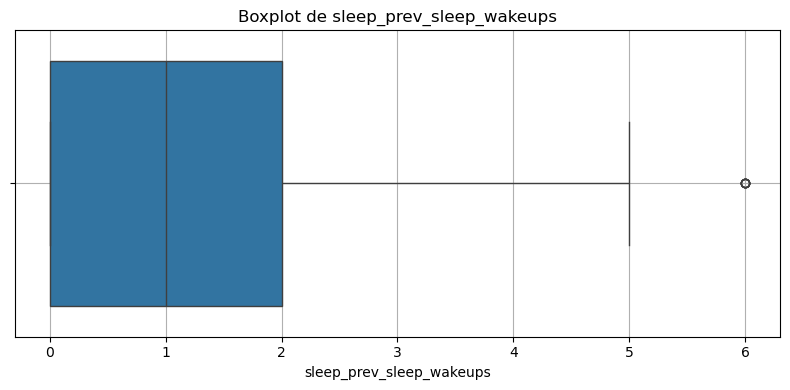

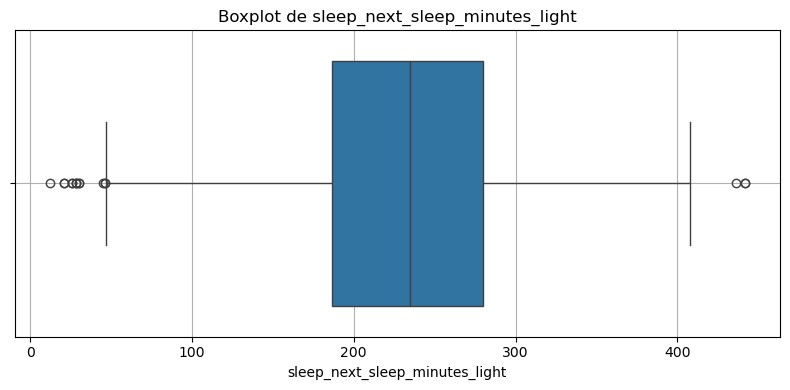

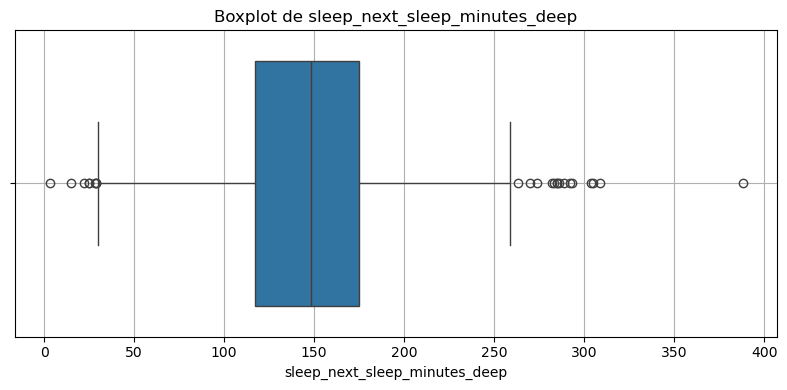

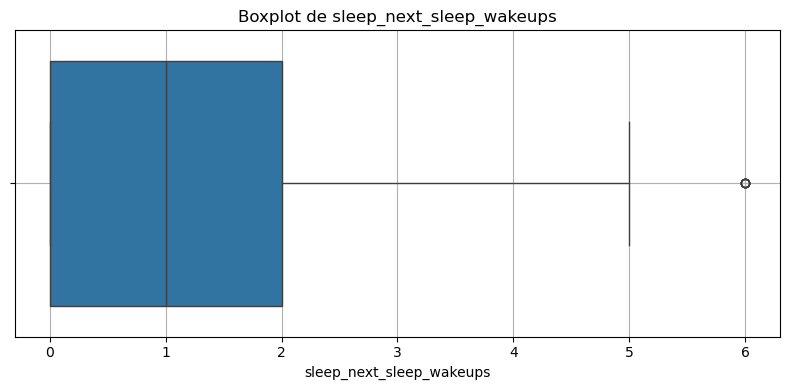

In [22]:

# Variables a graficar (sueño desglosado)
vars_sueno_extra = [
    'sleep_prev_sleep_minutes_light',
    'sleep_prev_sleep_minutes_deep',
    'sleep_prev_sleep_wakeups',
    'sleep_next_sleep_minutes_light',
    'sleep_next_sleep_minutes_deep',
    'sleep_next_sleep_wakeups'
]

# Histograma
for var in vars_sueno_extra:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_base, x=var, bins=30, kde=True)
    plt.title(f'Distribución de {var}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Boxplot
for var in vars_sueno_extra:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_base, x=var)
    plt.title(f'Boxplot de {var}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


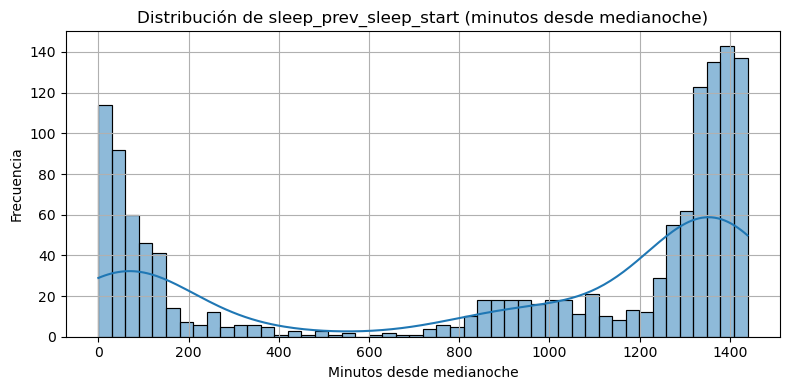

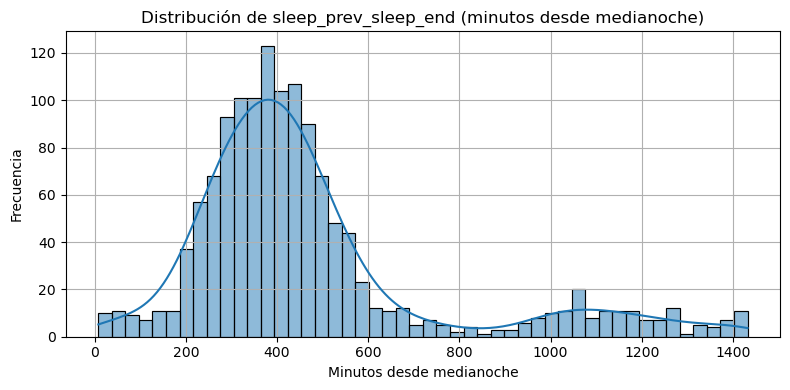

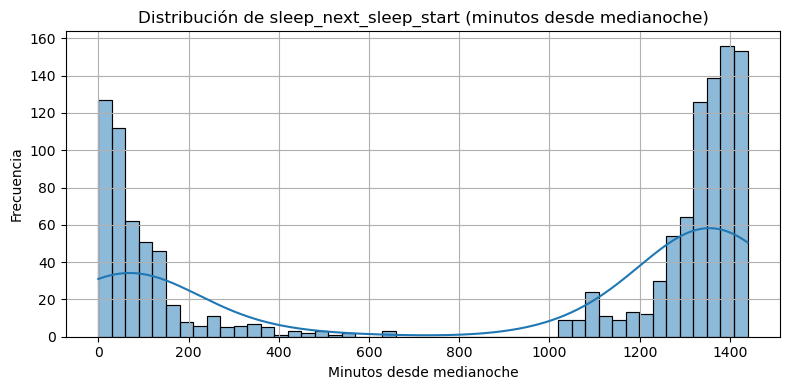

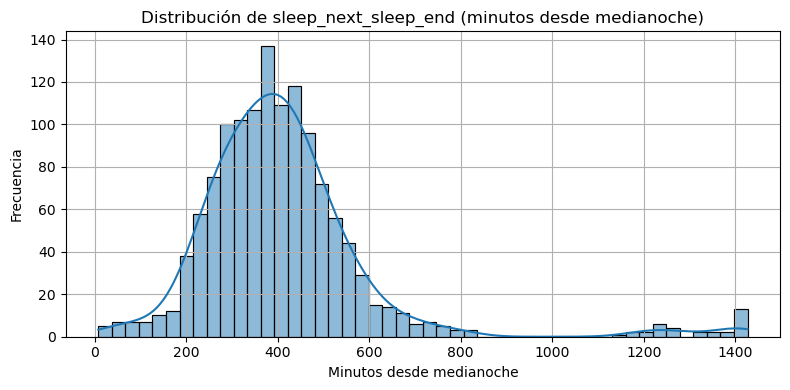

In [13]:
# Función para convertir hora (datetime.time) a minutos desde medianoche
def time_to_minutes(t):
    if pd.isnull(t):
        return None
    return t.hour * 60 + t.minute

# Aplicar a las columnas de hora
df_base['sleep_prev_sleep_start'] = df_base['sleep_prev_sleep_start'].apply(time_to_minutes)
df_base['sleep_prev_sleep_end'] = df_base['sleep_prev_sleep_end'].apply(time_to_minutes)
df_base['sleep_next_sleep_start'] = df_base['sleep_next_sleep_start'].apply(time_to_minutes)
df_base['sleep_next_sleep_end'] = df_base['sleep_next_sleep_end'].apply(time_to_minutes)

# Variables a graficar
time_vars = [
    'sleep_prev_sleep_start',
    'sleep_prev_sleep_end',
    'sleep_next_sleep_start',
    'sleep_next_sleep_end'
]

# Histogramas
import seaborn as sns
import matplotlib.pyplot as plt

for var in time_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_base, x=var, bins=48, kde=True)
    plt.title(f'Distribución de {var} (minutos desde medianoche)')
    plt.xlabel("Minutos desde medianoche")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


3. Limpieza de datos: detección y tratamiento de outliers.

In [14]:
df_base.dtypes

date                              datetime64[ns]
steps_total                                int64
steps_evening                            float64
activity_count                           float64
sleep_prev_sleep_start                   float64
sleep_prev_sleep_end                     float64
sleep_prev_sleep_minutes_total           float64
sleep_prev_sleep_minutes_light           float64
sleep_prev_sleep_minutes_deep            float64
sleep_prev_sleep_wakeups                 float64
sleep_next_sleep_start                   float64
sleep_next_sleep_end                     float64
sleep_next_sleep_minutes_total           float64
sleep_next_sleep_minutes_light           float64
sleep_next_sleep_minutes_deep            float64
sleep_next_sleep_wakeups                 float64
dtype: object

In [16]:
def eliminar_outliers_iqr(df, variables):
    df_clean = df.copy()

    for var in variables:
        if var not in df_clean.columns:
            continue

        Q1 = df_clean[var].quantile(0.25)
        Q3 = df_clean[var].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df_clean = df_clean[(df_clean[var].isna()) | ((df_clean[var] >= lower) & (df_clean[var] <= upper))]

    return df_clean

variables_outliers = [
    'steps_total',
    'steps_evening',
    'activity_count',
    'sleep_prev_sleep_minutes_total',
    'sleep_prev_sleep_minutes_light',
    'sleep_prev_sleep_minutes_deep',
    'sleep_prev_sleep_wakeups',
    'sleep_next_sleep_minutes_total',
    'sleep_next_sleep_minutes_light',
    'sleep_next_sleep_minutes_deep',
    'sleep_next_sleep_wakeups',
    'sleep_prev_sleep_start',
    'sleep_prev_sleep_end',
    'sleep_next_sleep_start',
    'sleep_next_sleep_end'
]

# Aplicamos la función
df_base = eliminar_outliers_iqr(df_base, variables_outliers)


In [17]:
print(f"Filas después de eliminar outliers: {len(df_base)}")


Filas después de eliminar outliers: 3708


In [26]:
df_base

,date,steps_total,steps_evening,activity_count,sleep_prev_sleep_start,sleep_prev_sleep_end,sleep_prev_sleep_minutes_total,sleep_prev_sleep_minutes_light,sleep_prev_sleep_minutes_deep,sleep_prev_sleep_wakeups,...,sleep_prev_sleep_minutes_deep_is_outlier,sleep_prev_sleep_wakeups_is_outlier,sleep_next_sleep_minutes_total_is_outlier,sleep_next_sleep_minutes_light_is_outlier,sleep_next_sleep_minutes_deep_is_outlier,sleep_next_sleep_wakeups_is_outlier,sleep_prev_sleep_start_is_outlier,sleep_prev_sleep_end_is_outlier,sleep_next_sleep_start_is_outlier,sleep_next_sleep_end_is_outlier
0,2013-06-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
1,2013-06-02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2,2013-06-03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
3,2013-06-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
4,2013-06-05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4278,2024-10-13,16236,6549.0,1.0,1425.0,355.0,361.0,259.0,102.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4279,2024-10-14,7685,714.0,2.0,1370.0,370.0,389.0,231.0,158.0,4.0,...,False,False,None,None,None,None,False,False,None,None
4280,2024-10-15,8741,657.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
4281,2024-10-16,8732,1715.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


4. Tratamiento de valores faltantes

In [27]:
# Ver número de valores nulos por columna
df_base.isna().sum().sort_values(ascending=False)


sleep_next_sleep_minutes_total               2996
sleep_next_sleep_minutes_light               2996
sleep_next_sleep_minutes_deep                2996
sleep_next_sleep_end                         2996
sleep_next_sleep_start                       2996
sleep_next_sleep_minutes_deep_is_outlier     2996
sleep_next_sleep_wakeups                     2996
sleep_next_sleep_end_is_outlier              2996
sleep_next_sleep_minutes_light_is_outlier    2996
sleep_next_sleep_minutes_total_is_outlier    2996
sleep_next_sleep_wakeups_is_outlier          2996
sleep_next_sleep_start_is_outlier            2996
sleep_prev_sleep_start                       2945
sleep_prev_sleep_end                         2945
sleep_prev_sleep_minutes_total               2945
sleep_prev_sleep_minutes_total_is_outlier    2945
sleep_prev_sleep_minutes_light_is_outlier    2945
sleep_prev_sleep_end_is_outlier              2945
sleep_prev_sleep_wakeups_is_outlier          2945
sleep_prev_sleep_minutes_deep                2945


In [18]:
# Eliminar días sin ningún registro real (pasos = 0 y todo lo demás NaN)
cond_sin_registro = (
    (df_base['steps_total'] == 0) &
    (df_base['steps_evening'].isna()) &
    (df_base['activity_count'].isna()) &
    (df_base['sleep_prev_sleep_minutes_total'].isna()) &
    (df_base['sleep_next_sleep_minutes_total'].isna())
)

# Mostrar cuántos días se eliminan
print(f"Número de días sin registro real (sin uso del dispositivo): {cond_sin_registro.sum()}")

# Filtrar el DataFrame
df_base = df_base[~cond_sin_registro].copy()


Número de días sin registro real (sin uso del dispositivo): 2582


In [19]:
# Reiniciar índices tras eliminar registros sin información
df_base.reset_index(drop=True, inplace=True)


In [30]:
df_base

,date,steps_total,steps_evening,activity_count,sleep_prev_sleep_start,sleep_prev_sleep_end,sleep_prev_sleep_minutes_total,sleep_prev_sleep_minutes_light,sleep_prev_sleep_minutes_deep,sleep_prev_sleep_wakeups,...,sleep_prev_sleep_minutes_deep_is_outlier,sleep_prev_sleep_wakeups_is_outlier,sleep_next_sleep_minutes_total_is_outlier,sleep_next_sleep_minutes_light_is_outlier,sleep_next_sleep_minutes_deep_is_outlier,sleep_next_sleep_wakeups_is_outlier,sleep_prev_sleep_start_is_outlier,sleep_prev_sleep_end_is_outlier,sleep_next_sleep_start_is_outlier,sleep_next_sleep_end_is_outlier
0,2018-04-26,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,False,False,False,False,None,None,False,False
1,2018-04-27,15305,698.0,1.0,1330.0,227.0,327.0,182.0,145.0,1.0,...,False,False,False,False,False,False,False,False,False,False
2,2018-04-28,12492,1100.0,3.0,1427.0,425.0,399.0,295.0,104.0,2.0,...,False,False,False,False,False,False,False,False,False,False
3,2018-04-29,9163,200.0,2.0,1400.0,438.0,453.0,329.0,124.0,1.0,...,False,False,False,False,False,False,False,False,False,False
4,2018-04-30,5089,1840.0,2.0,75.0,454.0,353.0,229.0,124.0,2.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,2024-10-13,16236,6549.0,1.0,1425.0,355.0,361.0,259.0,102.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1697,2024-10-14,7685,714.0,2.0,1370.0,370.0,389.0,231.0,158.0,4.0,...,False,False,None,None,None,None,False,False,None,None
1698,2024-10-15,8741,657.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
1699,2024-10-16,8732,1715.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


In [31]:
# Mostrar valores faltantes por columna
df_base.isna().sum().sort_values(ascending=False)


sleep_next_sleep_minutes_total               414
sleep_next_sleep_minutes_light               414
sleep_next_sleep_minutes_deep                414
sleep_next_sleep_end                         414
sleep_next_sleep_start                       414
sleep_next_sleep_minutes_deep_is_outlier     414
sleep_next_sleep_wakeups                     414
sleep_next_sleep_end_is_outlier              414
sleep_next_sleep_minutes_light_is_outlier    414
sleep_next_sleep_minutes_total_is_outlier    414
sleep_next_sleep_wakeups_is_outlier          414
sleep_next_sleep_start_is_outlier            414
sleep_prev_sleep_start                       363
sleep_prev_sleep_end                         363
sleep_prev_sleep_minutes_total               363
sleep_prev_sleep_minutes_total_is_outlier    363
sleep_prev_sleep_minutes_light_is_outlier    363
sleep_prev_sleep_end_is_outlier              363
sleep_prev_sleep_wakeups_is_outlier          363
sleep_prev_sleep_minutes_deep                363
sleep_prev_sleep_min

In [20]:
from sklearn.impute import SimpleImputer

# Crear imputador para la mediana
imputer = SimpleImputer(strategy='median')

# Aplicar solo a la columna activity_count (reshape para cumplir con .fit_transform)
df_base['activity_count'] = imputer.fit_transform(df_base[['activity_count']])


In [33]:
df_base.isna().sum().sort_values(ascending=False)

sleep_next_sleep_minutes_total               414
sleep_next_sleep_minutes_light               414
sleep_next_sleep_minutes_deep                414
sleep_next_sleep_end                         414
sleep_next_sleep_start                       414
sleep_next_sleep_minutes_deep_is_outlier     414
sleep_next_sleep_wakeups                     414
sleep_next_sleep_end_is_outlier              414
sleep_next_sleep_minutes_light_is_outlier    414
sleep_next_sleep_minutes_total_is_outlier    414
sleep_next_sleep_wakeups_is_outlier          414
sleep_next_sleep_start_is_outlier            414
sleep_prev_sleep_start                       363
sleep_prev_sleep_end                         363
sleep_prev_sleep_minutes_total               363
sleep_prev_sleep_minutes_total_is_outlier    363
sleep_prev_sleep_minutes_light_is_outlier    363
sleep_prev_sleep_end_is_outlier              363
sleep_prev_sleep_wakeups_is_outlier          363
sleep_prev_sleep_minutes_deep                363
sleep_prev_sleep_min

In [21]:

# Variables numéricas con NaNs que queremos imputar
cols_imputar = [
    'sleep_next_sleep_minutes_total',
    'sleep_next_sleep_minutes_light',
    'sleep_next_sleep_minutes_deep',
    'sleep_next_sleep_wakeups',
    'sleep_prev_sleep_start',
    'sleep_prev_sleep_end',
    'sleep_prev_sleep_minutes_total',
    'sleep_prev_sleep_minutes_light',
    'sleep_prev_sleep_minutes_deep',
    'sleep_prev_sleep_wakeups',
    'sleep_next_sleep_start',
    'sleep_next_sleep_end',
    'steps_evening'
]


# Convertir a numérico si hay strings (por seguridad)
for col in cols_imputar:
    df_base[col] = pd.to_numeric(df_base[col], errors='coerce')

# 2. Imputar con mediana
imputer = SimpleImputer(strategy='median')
df_base[cols_imputar] = imputer.fit_transform(df_base[cols_imputar])


In [22]:
df_base.isna().sum().sort_values(ascending=False)

date                              0
steps_total                       0
steps_evening                     0
activity_count                    0
sleep_prev_sleep_start            0
sleep_prev_sleep_end              0
sleep_prev_sleep_minutes_total    0
sleep_prev_sleep_minutes_light    0
sleep_prev_sleep_minutes_deep     0
sleep_prev_sleep_wakeups          0
sleep_next_sleep_start            0
sleep_next_sleep_end              0
sleep_next_sleep_minutes_total    0
sleep_next_sleep_minutes_light    0
sleep_next_sleep_minutes_deep     0
sleep_next_sleep_wakeups          0
dtype: int64

In [23]:
df_base.isna().sum().sum()

0

5. Normalización de variables

In [24]:
df_base.dtypes

date                              datetime64[ns]
steps_total                                int64
steps_evening                            float64
activity_count                           float64
sleep_prev_sleep_start                   float64
sleep_prev_sleep_end                     float64
sleep_prev_sleep_minutes_total           float64
sleep_prev_sleep_minutes_light           float64
sleep_prev_sleep_minutes_deep            float64
sleep_prev_sleep_wakeups                 float64
sleep_next_sleep_start                   float64
sleep_next_sleep_end                     float64
sleep_next_sleep_minutes_total           float64
sleep_next_sleep_minutes_light           float64
sleep_next_sleep_minutes_deep            float64
sleep_next_sleep_wakeups                 float64
dtype: object

In [25]:
cols_escalar = [
    'steps_total',
    'steps_evening',
    'activity_count',
    'sleep_prev_sleep_start',
    'sleep_prev_sleep_end',
    'sleep_prev_sleep_minutes_total',
    'sleep_prev_sleep_minutes_light',
    'sleep_prev_sleep_minutes_deep',
    'sleep_prev_sleep_wakeups',
    'sleep_next_sleep_start',
    'sleep_next_sleep_end',
    'sleep_next_sleep_minutes_total',
    'sleep_next_sleep_minutes_light',
    'sleep_next_sleep_minutes_deep',
    'sleep_next_sleep_wakeups'
]


In [26]:
from sklearn.preprocessing import StandardScaler

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar
df_base[cols_escalar] = scaler.fit_transform(df_base[cols_escalar])


In [27]:
df_base

,date,steps_total,steps_evening,activity_count,sleep_prev_sleep_start,sleep_prev_sleep_end,sleep_prev_sleep_minutes_total,sleep_prev_sleep_minutes_light,sleep_prev_sleep_minutes_deep,sleep_prev_sleep_wakeups,sleep_next_sleep_start,sleep_next_sleep_end,sleep_next_sleep_minutes_total,sleep_next_sleep_minutes_light,sleep_next_sleep_minutes_deep,sleep_next_sleep_wakeups
0,2018-04-26,-1.679307,-0.263205,-0.729070,0.550282,-0.011317,0.037830,-0.009350,0.025137,-0.144910,0.582497,-1.513380,-0.919399,-1.019401,-0.239750,-0.151832
1,2018-04-27,1.845340,-0.551513,-0.729070,0.598925,-1.505644,-0.864832,-1.019033,-0.141025,-0.144910,0.759556,0.498648,0.134969,1.139854,-1.421761,0.995567
2,2018-04-28,1.197523,-0.130059,2.528600,0.773679,0.421891,0.166782,1.093823,-1.276466,0.996131,0.710272,0.630751,0.925745,1.789541,-0.845170,-0.151832
3,2018-04-29,0.430875,-1.073611,0.899765,0.725036,0.548447,0.940493,1.729550,-0.722592,-0.144910,-1.708311,0.793339,-0.538655,-0.121304,-0.845170,0.995567
4,2018-05-02,1.409394,0.552444,0.899765,-1.584592,0.879438,-0.793192,-0.813357,-0.307187,0.996131,0.715748,-1.950336,-2.603458,-2.299668,-1.623568,-1.299230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,2024-10-08,-1.361732,-1.041111,-0.729070,0.658377,-0.522406,0.138126,0.196327,-0.002557,-1.285952,0.708446,0.346222,0.471781,0.738576,-0.153261,0.995567
1122,2024-10-14,0.090501,-0.534738,0.899765,0.670988,-0.113535,0.023502,-0.102839,0.218992,3.278215,0.527737,0.000722,0.032461,-0.006653,-0.009114,-0.151832
1123,2024-10-15,0.333691,-0.594497,0.899765,0.550282,-0.011317,0.037830,-0.009350,0.025137,-0.144910,0.527737,0.000722,0.032461,-0.006653,-0.009114,-0.151832
1124,2024-10-16,0.331619,0.514701,-0.729070,0.550282,-0.011317,0.037830,-0.009350,0.025137,-0.144910,0.527737,0.000722,0.032461,-0.006653,-0.009114,-0.151832


6. Selección de variables relevantes. 
Las variables utilizadas en este análisis han sido seleccionadas en base a estudios previos que empleaban esta misma fuente de datos. Por tanto, no se ha realizado una selección automática mediante algoritmos, sino una preselección fundamentada en evidencia científica previa sobre su relevancia en el análisis de trastornos afectivos.

7. Reducción de dimensionalidad: Análisis de Componentes Principales (PCA).

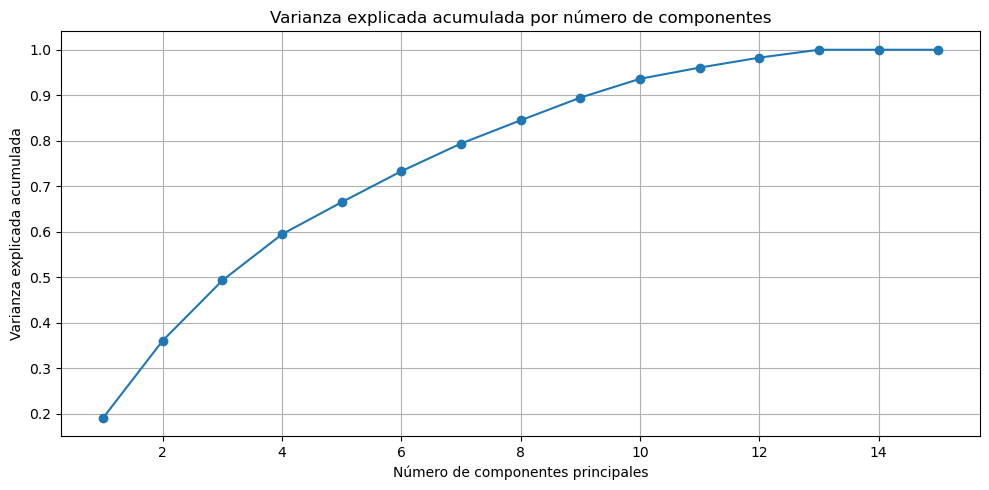

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# 1. Seleccionar todas las columnas numéricas (ya escaladas y codificadas)
X = df_base.select_dtypes(include=['float64', 'int64', 'bool'])

# 2. Ajustar PCA sin definir número de componentes para ver la varianza acumulada
pca_full = PCA()
pca_full.fit(X)

# 3. Visualizar la varianza explicada acumulada
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
         pca_full.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Varianza explicada acumulada por número de componentes')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:

# Aplicar PCA conservando 12 componentes principales
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X)

# Crear DataFrame con las nuevas variables
cols_pca = [f'PC{i+1}' for i in range(12)]
df_pca = pd.DataFrame(X_pca, columns=cols_pca, index=df_base.index)

# (Opcional) Concatenar con df_base si quieres conservar las demás columnas
df_base_pca = pd.concat([df_base.reset_index(drop=True), df_pca], axis=1)


In [29]:
# Guardar el DataFrame preprocesado sin aplicar PCA
df_base.to_csv("dataset_preprocesado2.csv", index=False)

In [30]:
df_base.shape

(1126, 16)

In [33]:
# Supongamos que 'df_base' tiene la columna 'date' y las demás escaladas

# Extraemos la columna fecha
df_date = df_base['date']

# Extraemos solo las columnas numéricas para desescalar
df_numeric = df_base.drop(columns=['date'])

# Aplicamos inverse_transform solo a las columnas numéricas
df_numeric_original = pd.DataFrame(scaler.inverse_transform(df_numeric), columns=df_numeric.columns)

# Volvemos a añadir la columna fecha
df_original = pd.concat([df_date, df_numeric_original], axis=1)



In [34]:
df_original.to_csv("dataset_sin_escalar.csv", index=False)